In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [3]:
def get_data(colOfInterest, **kwargs):
    """
    Retrieves and processes data based on the specified level of aggregation and optional parameters.

    Parameters:
    colOfInterest (str): Indicates the level of aggregation. It can be "Kingdom", "Phylum", "Class", "Order", "Family", "Genus", or "Species".
    **kwargs: Optional keyword arguments.
        - percentage_threshold (float): The cumulative percentage of abundance to include. For example, if percentage_threshold = 80, the returned data will account for 80% of the total abundance.
        - threshold (int): The number of top ESVs to include. Overrided by percentage_threshold if provided.

    Returns:
    pandas.DataFrame: The processed data containing ESVs aggregated to the specified level of interest, along with sample metadata.

    """
    percentage_threshold = kwargs.get("percentage_threshold", None)
    threshold = kwargs.get("threshold", None)

    # Load sample metadata
    df = pd.read_csv('summarized_meta_mani-final.csv')
    colsToDrop = [col if 'Unnamed' in col else None for col in df.columns]
    colsToDrop = [col for col in colsToDrop if col is not None]
    df.drop(colsToDrop,axis=1,inplace=True)
    df["Date"] = pd.to_datetime(df["Date"], dayfirst=True)
    df["Year"] = df["Date"].dt.year
    df["Month"] = df["Date"].dt.month
    df["Day"] = df["Date"].dt.day

    # Load ESV data and labels ESVs with taxonomy
    ESV_df = pd.read_table("resample_merged.grouped.filtered.otu-table.chname.txt")
    ESV_lookup =pd.read_table("merged.taxonomy.txt")
    labelled_ESV_df = ESV_lookup.merge(ESV_df, left_on="ESVs", right_on=" ID", how="inner") # ESV - Exact Sequence Variant - See ASV (https://zymoresearch.eu/blogs/blog/microbiome-informatics-otu-vs-asv)

    # Aggregating ESVs to the level of interest
    agg_df = labelled_ESV_df.groupby(colOfInterest).sum(numeric_only=True)
    totals = agg_df.sum(axis=1).sort_values(ascending=False).to_frame(name="Total")
    totals.index.name = colOfInterest
    totals["Cumulative Percentage"] = 100 * totals["Total"].cumsum() / totals["Total"].sum()
    if percentage_threshold is not None:
        threshold = (totals["Cumulative Percentage"] < percentage_threshold).sum() + 1
    else:
        threshold = threshold if threshold is not None else 10
    ESV_list = totals.index[:threshold]
    agg_df2 = agg_df.loc[ESV_list].copy().T
    agg_df2.reset_index(inplace=True)
    agg_df2.rename(columns = {"index": "Sample ID"}, inplace=True)
    if "uncultured" in agg_df2.columns or "uncultured bacterium" in agg_df2.columns:
        agg_df2["Unclassified"] = agg_df2.get("uncultured", 0) + agg_df2.get("uncultured bacterium", 0)
        agg_df2.drop(["uncultured", "uncultured bacterium"], axis=1, inplace=True, errors="ignore")
    # TODO This doesn't work at the moment, but it should be possible to aggregate the data into an "Other" category
    #other_list = totals.index[threshold:]
    #other_list = [x for x in other_list if x not in ["uncultured", "uncultured bacterium"]]
    #agg_df2["Other"] = agg_df2[other_list].sum(axis=1)
    final_df = agg_df2.merge(df, left_on="Sample ID", right_on="Sample", how="inner")
    return final_df
df=get_data("Phylum", threshold=10)
print(df.columns)
df.head()

Index(['Sample ID', 'Proteobacteria', 'Bacteroidetes', 'Epsilonbacteraeota',
       'Firmicutes', 'Chloroflexi', 'Actinobacteria', 'Acidobacteria',
       'Patescibacteria', 'Verrucomicrobia', 'Planctomycetes', 'Sample',
       'WWTP ID', 'Date', 'Position', 'City', 'Country', 'Latitude',
       'Longitude', 'Continent', 'Climate type', 'GDP per capita (dollars)',
       'City population', 'Ambient Temperature (℃) Max.SamplingDate',
       'Ambient Temperature (℃) Avg.SamplingDate',
       'Ambient Temperature (℃) Min.SamplingDate',
       'Ambient Temperature (℃) Max.WeekMean',
       'Ambient Temperature (℃) Avg.WeekMean',
       'Ambient Temperature (℃) Min.WeekMean',
       'Ambient Temperature (℃) Max.WeekMax',
       'Ambient Temperature (℃) Avg.WeekMax',
       'Ambient Temperature (℃) Min.WeekMax', 'Wind (mph) Max.SamplingDate',
       'Wind (mph) Min.SamplingDate', 'Wind (mph) Max.WeekMean',
       'Wind (mph) Min.WeekMean', 'Wind (mph)Max.WeekMax',
       'Wind (mph)Min.WeekM

,Sample ID,Proteobacteria,Bacteroidetes,Epsilonbacteraeota,Firmicutes,Chloroflexi,Actinobacteria,Acidobacteria,Patescibacteria,Verrucomicrobia,...,Arsenic (mg/L),Cadmium (mg/L),Sulphur (mg/L),Sillicon (mg/L),Nickel (mg/L),Chromium (mg/L),Mercury (mg/L),Year,Month,Day
0,UK01A,9304,3921,74,193,59,649,25,417,214,...,0.00,0.00,25.69,0.05,0.01,0.00,NaN,2015,1,28
1,UK02A,15986,7298,268,432,97,867,33,809,328,...,0.00,0.00,26.16,0.65,0.01,0.00,NaN,2015,2,4
2,UK03A,14877,8391,170,373,84,876,43,758,333,...,0.01,0.00,25.94,0.17,0.00,0.00,NaN,2015,2,11
3,UK04A,15518,8050,234,383,106,608,33,632,270,...,0.01,0.00,27.65,0.13,0.02,0.00,NaN,2015,2,18
4,UK05A,15202,8428,210,499,70,504,28,767,256,...,0.00,0.00,26.16,0.06,0.01,0.00,NaN,2015,2,25


In [4]:
# Load the data
# Only first 68 columns are useful (rest are empty). Last useful column is "Mercury (mg/L)"
df = pd.read_csv('summarized_meta_mani-final.csv')
colsToDrop = [col if 'Unnamed' in col else None for col in df.columns]
colsToDrop = [col for col in colsToDrop if col is not None]
df.drop(colsToDrop,axis=1,inplace=True)
df["Date"] = pd.to_datetime(df["Date"], dayfirst=True)
df["Year"] = df["Date"].dt.year
df["Month"] = df["Date"].dt.month
df["Day"] = df["Date"].dt.day
print(df.columns)
df.head()

Index(['Sample', 'WWTP ID', 'Date', 'Position', 'City', 'Country', 'Latitude',
       'Longitude', 'Continent', 'Climate type', 'GDP per capita (dollars)',
       'City population', 'Ambient Temperature (℃) Max.SamplingDate',
       'Ambient Temperature (℃) Avg.SamplingDate',
       'Ambient Temperature (℃) Min.SamplingDate',
       'Ambient Temperature (℃) Max.WeekMean',
       'Ambient Temperature (℃) Avg.WeekMean',
       'Ambient Temperature (℃) Min.WeekMean',
       'Ambient Temperature (℃) Max.WeekMax',
       'Ambient Temperature (℃) Avg.WeekMax',
       'Ambient Temperature (℃) Min.WeekMax', 'Wind (mph) Max.SamplingDate',
       'Wind (mph) Min.SamplingDate', 'Wind (mph) Max.WeekMean',
       'Wind (mph) Min.WeekMean', 'Wind (mph)Max.WeekMax',
       'Wind (mph)Min.WeekMax', 'Precipitation (inches) SamplingDate',
       'Precipitation (inches) WeekMean', 'Precipitation (inches) WeekMax',
       'Precipitation (inches) WeekAccum', 'Precipitation (inches)MonthAccum',
       'Ambi

,Sample,WWTP ID,Date,Position,City,Country,Latitude,Longitude,Continent,Climate type,...,Arsenic (mg/L),Cadmium (mg/L),Sulphur (mg/L),Sillicon (mg/L),Nickel (mg/L),Chromium (mg/L),Mercury (mg/L),Year,Month,Day
0,UK01A,UKTM1A,2015-01-28,NewcastleAS,Newcastle,United Kindom,54.7155,-1.6136,Europe,Cfb,...,0.00,0.00,25.69,0.05,0.01,0.00,NaN,2015,1,28
1,UK02A,UKTM1A,2015-02-04,NewcastleAS,Newcastle,United Kindom,54.7155,-1.6136,Europe,Cfb,...,0.00,0.00,26.16,0.65,0.01,0.00,NaN,2015,2,4
2,UK03A,UKTM1A,2015-02-11,NewcastleAS,Newcastle,United Kindom,54.7155,-1.6136,Europe,Cfb,...,0.01,0.00,25.94,0.17,0.00,0.00,NaN,2015,2,11
3,UK04A,UKTM1A,2015-02-18,NewcastleAS,Newcastle,United Kindom,54.7155,-1.6136,Europe,Cfb,...,0.01,0.00,27.65,0.13,0.02,0.00,NaN,2015,2,18
4,UK05A,UKTM1A,2015-02-25,NewcastleAS,Newcastle,United Kindom,54.7155,-1.6136,Europe,Cfb,...,0.00,0.00,26.16,0.06,0.01,0.00,NaN,2015,2,25


In [18]:
df["WWTP ID"].value_counts().sort_index()

WWTP ID
CNBJ2A     94
CNBJ3A     97
CNGZ1A     99
PTLB1      94
SAKB1     152
SEGL1A    104
UKTM1A     51
USCG5      56
USKN1     141
USNO2     259
USSF1A    104
Name: count, dtype: int64

In [20]:
df["Year"].value_counts().sort_index()

Year
2014      86
2015    1026
2016     139
Name: count, dtype: int64

In [49]:
# Data is weekly over 1 year 
df[df["City"]=="Newcastle"]

,Sample,WWTP ID,Date,Position,City,Country,Latitude,Longitude,Continent,Climate type,...,Cadmium (mg/L),Sulphur (mg/L),Sillicon (mg/L),Nickel (mg/L),Chromium (mg/L),Mercury (mg/L),Year,Month,Day,COD Removal (%)
0,UK01A,UKTM1A,2015-01-28,NewcastleAS,Newcastle,United Kindom,54.7155,-1.6136,Europe,Cfb,...,0.0,25.69,0.05,0.01,0.0,NaN,2015,1,28,52.813853
1,UK02A,UKTM1A,2015-02-04,NewcastleAS,Newcastle,United Kindom,54.7155,-1.6136,Europe,Cfb,...,0.0,26.16,0.65,0.01,0.0,NaN,2015,2,4,63.486842
2,UK03A,UKTM1A,2015-02-11,NewcastleAS,Newcastle,United Kindom,54.7155,-1.6136,Europe,Cfb,...,0.0,25.94,0.17,0.00,0.0,NaN,2015,2,11,38.743455
3,UK04A,UKTM1A,2015-02-18,NewcastleAS,Newcastle,United Kindom,54.7155,-1.6136,Europe,Cfb,...,0.0,27.65,0.13,0.02,0.0,NaN,2015,2,18,46.759259
4,UK05A,UKTM1A,2015-02-25,NewcastleAS,Newcastle,United Kindom,54.7155,-1.6136,Europe,Cfb,...,0.0,26.16,0.06,0.01,0.0,NaN,2015,2,25,46.634615
5,UK06A,UKTM1A,2015-03-04,NewcastleAS,Newcastle,United Kindom,54.7155,-1.6136,Europe,Cfb,...,0.0,26.06,0.94,0.00,0.0,NaN,2015,3,4,54.625551
6,UK08A,UKTM1A,2015-03-18,NewcastleAS,Newcastle,United Kindom,54.7155,-1.6136,Europe,Cfb,...,0.0,26.60,0.17,0.00,0.0,NaN,2015,3,18,32.065217
7,UK09A,UKTM1A,2015-03-25,NewcastleAS,Newcastle,United Kindom,54.7155,-1.6136,Europe,Cfb,...,0.0,21.03,2.76,0.00,0.0,NaN,2015,3,25,39.459459
8,UK10A,UKTM1A,2015-04-01,NewcastleAS,Newcastle,United Kindom,54.7155,-1.6136,Europe,Cfb,...,0.0,21.99,0.47,0.00,0.0,NaN,2015,4,1,39.344262
9,UK11A,UKTM1A,2015-04-08,NewcastleAS,Newcastle,United Kindom,54.7155,-1.6136,Europe,Cfb,...,0.0,25.19,0.12,0.00,0.0,NaN,2015,4,8,71.508380


In [14]:
eco_df = pd.read_table("env2_7days.txt")
colsToDrop_season = ["season1", "season2", "season3", "Season"]
colsToDrop_plant = ["plant" + str(i) for i in range(1, 11)]
colsToDrop = colsToDrop_season + colsToDrop_plant
eco_df.drop(colsToDrop, axis=1, inplace=True)
print(eco_df.columns)
eco_df.head()

Index(['Samples', 'Position', 'AS', 'Country', 'City', 'Plant', 'Date',
       'Date00', 'richness', 'shannon', 'pielou', 'S.chao1', 'BrayPC1',
       'jsd.PC1', 'BrayPC2', 'jsd.PC2', 'Flowrate', 'COD.rm', 'BOD.rm',
       'NH4.rm', 'TN.rm', 'TP.rm', 'COD.rmr', 'BOD.rmr', 'NH4.rmr', 'TN.rmr',
       'TP.rmr', 'FM', 'pH', 'DO', 'Temp.AS', 'MLSS', 'MLVSS', 'SVI', 'SRT',
       'Temp.Avg.SamplingDate', 'Precipitation.SamplingDate',
       'Temp.Avg.WeekMean', 'Precipitation.WeekMean',
       'Precipitation.WeekAccum', 'Precipitation.MonthAccum'],
      dtype='object')


,Samples,Position,AS,Country,City,Plant,Date,Date00,richness,shannon,...,MLSS,MLVSS,SVI,SRT,Temp.Avg.SamplingDate,Precipitation.SamplingDate,Temp.Avg.WeekMean,Precipitation.WeekMean,Precipitation.WeekAccum,Precipitation.MonthAccum
0,UK01A,NewcastleAS,AS,United Kindom,Newcastle,UKTM1A,2015-01-28,211,295.0,4.522435,...,2790.0,2190.0,257.0,10.68,3.33,0.0,5.40,0.0,0.0,0.0
1,UK02A,NewcastleAS,AS,United Kindom,Newcastle,UKTM1A,2015-02-04,218,612.0,4.926299,...,2710.0,2280.0,260.0,9.79,3.33,0.0,2.46,0.0,0.0,0.0
2,UK03A,NewcastleAS,AS,United Kindom,Newcastle,UKTM1A,2015-02-11,225,447.0,4.819278,...,3540.0,2570.0,340.0,12.76,4.44,0.0,5.24,0.0,0.0,0.0
3,UK04A,NewcastleAS,AS,United Kindom,Newcastle,UKTM1A,2015-02-18,232,469.0,4.744337,...,3400.0,2500.0,326.0,NaN,10.00,0.0,6.67,0.0,0.0,0.0
4,UK05A,NewcastleAS,AS,United Kindom,Newcastle,UKTM1A,2015-02-25,239,403.0,4.668548,...,3130.0,2320.0,282.0,7.65,7.78,0.0,5.08,0.0,0.0,0.0


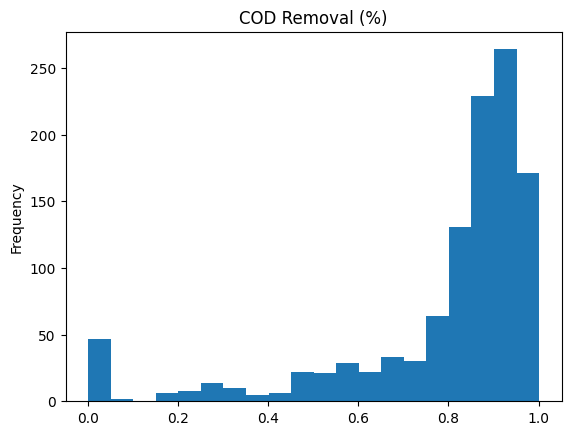

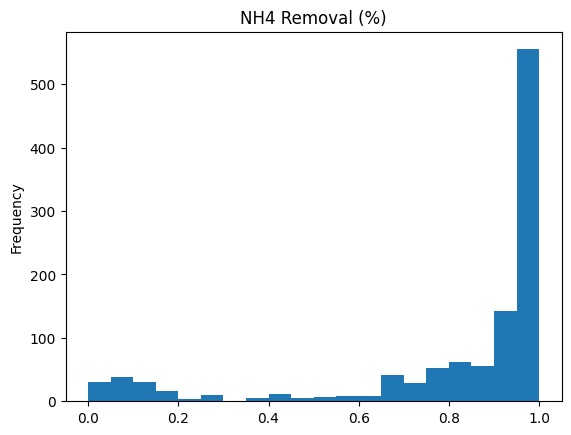

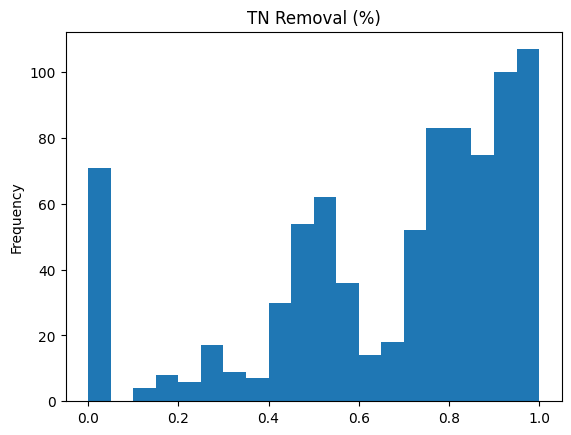

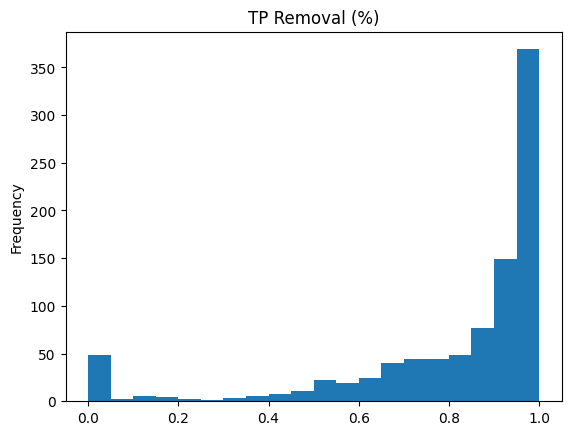

In [46]:
eco_df["COD.rm"].clip(lower=0, inplace=True)
eco_df["COD.rm"].plot.hist(bins=20, title = "COD Removal (%)")
plt.show()

eco_df["NH4.rm"].clip(lower=0, inplace=True)
eco_df["NH4.rm"].plot.hist(bins=20, title = "NH4 Removal (%)")
plt.show()

eco_df["TN.rm"].clip(lower=0, inplace=True)
eco_df["TN.rm"].plot.hist(bins=20, title = "TN Removal (%)")
plt.show()

eco_df["TP.rm"].clip(lower=0, inplace=True)
eco_df["TP.rm"].plot.hist(bins=20, title = "TP Removal (%)")
plt.show()



In [15]:
ESV_df = pd.read_table("resample_merged.grouped.filtered.otu-table.chname.txt")
ESV_df.rename(columns = {" ID":"ID"}, inplace=True)
for col in ESV_df.columns:
    if col != "ID":
        ESV_df[col] = ESV_df[col].astype(int)
ESV_df.head()

,ID,UK01A,UK02A,UK03A,UK04A,UK05A,UK06A,UK08A,UK09A,UK10A,...,N52B,N52C,N52I,N52E,GZ100,GZ101,GZ102,GZ103,GZ104,N01A
0,ESV1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,10
1,ESV2,1350,1663,1724,1603,1613,1696,1734,1084,1045,...,1411,1770,517,1936,0,0,0,0,0,176
2,ESV3,641,1124,1129,985,799,895,727,720,682,...,0,0,0,0,0,0,0,0,0,26
3,ESV4,0,0,0,0,0,0,0,0,0,...,0,32,77,48,0,30,0,0,0,0
4,ESV5,314,507,490,632,633,723,933,800,712,...,0,0,0,0,0,0,0,0,0,0


In [16]:
ESV_lookup =pd.read_table("merged.taxonomy.txt")
ESV_lookup["Lowest Level Classification"] = ESV_lookup["Leastone2"].str.split("_").str[1]
ESV_lookup["Lowest Level Name"] = ESV_lookup["Leastone2"].str.split("_").str[-1]
ESV_lookup.head()

,ESVs,Kingdom,Phylum,Order,Class,Family,Genus,Species,Leastone2,Lowest Level Classification,Lowest Level Name
0,ESV34208,Bacteria,Lentisphaerae,Lentisphaeria,Victivallales,GWF2-44-16,uncultured bacterium,uncultured bacterium,D_4__GWF2-44-16,4,GWF2-44-16
1,ESV1,Bacteria,Bacteroidetes,Bacteroidia,Chitinophagales,Saprospiraceae,uncultured,NaN,D_4__Saprospiraceae,4,Saprospiraceae
2,ESV10,Bacteria,Firmicutes,Bacilli,Lactobacillales,Carnobacteriaceae,Trichococcus,NaN,D_5__Trichococcus,5,Trichococcus
3,ESV100,Bacteria,Proteobacteria,Gammaproteobacteria,Betaproteobacteriales,Burkholderiaceae,Rhodoferax,NaN,D_5__Rhodoferax,5,Rhodoferax
4,ESV1000,Bacteria,Acidobacteria,Blastocatellia (Subgroup 4),24-Nov,uncultured bacterium,uncultured bacterium,uncultured bacterium,D_3__11-24,3,11-24


In [17]:
labelled_ESV_df = ESV_lookup.merge(ESV_df, left_on="ESVs", right_on="ID", how="inner") # ESV - Exact Sequence Variant - See ASV (https://zymoresearch.eu/blogs/blog/microbiome-informatics-otu-vs-asv)
labelled_ESV_df.head()

,ESVs,Kingdom,Phylum,Order,Class,Family,Genus,Species,Leastone2,Lowest Level Classification,...,N52B,N52C,N52I,N52E,GZ100,GZ101,GZ102,GZ103,GZ104,N01A
0,ESV34208,Bacteria,Lentisphaerae,Lentisphaeria,Victivallales,GWF2-44-16,uncultured bacterium,uncultured bacterium,D_4__GWF2-44-16,4,...,0,0,0,0,0,0,0,0,0,0
1,ESV1,Bacteria,Bacteroidetes,Bacteroidia,Chitinophagales,Saprospiraceae,uncultured,NaN,D_4__Saprospiraceae,4,...,0,0,0,0,0,0,0,0,0,10
2,ESV10,Bacteria,Firmicutes,Bacilli,Lactobacillales,Carnobacteriaceae,Trichococcus,NaN,D_5__Trichococcus,5,...,141,166,224,151,18,180,157,74,90,29
3,ESV100,Bacteria,Proteobacteria,Gammaproteobacteria,Betaproteobacteriales,Burkholderiaceae,Rhodoferax,NaN,D_5__Rhodoferax,5,...,0,0,0,0,0,0,0,0,0,0
4,ESV1000,Bacteria,Acidobacteria,Blastocatellia (Subgroup 4),24-Nov,uncultured bacterium,uncultured bacterium,uncultured bacterium,D_3__11-24,3,...,0,0,0,0,0,0,1,0,0,0


In [18]:
colsToDrop = ["Species", "Genus", "Family", "Order", "Class", "Phylum", "Kingdom","Leastone2", "Lowest Level Classification", "Lowest Level Name", "ESVs", "ID"]
colOfInterest = "Phylum"
colsToDrop.remove(colOfInterest)
agg_df = labelled_ESV_df.groupby(colOfInterest).sum(numeric_only=True).copy()
agg_df.reset_index(inplace=True)
agg_df.head()

,Phylum,UK01A,UK02A,UK03A,UK04A,UK05A,UK06A,UK08A,UK09A,UK10A,...,N52B,N52C,N52I,N52E,GZ100,GZ101,GZ102,GZ103,GZ104,N01A
0,Acetothermia,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,2
1,Acidobacteria,25,33,43,33,28,29,26,28,24,...,32,38,57,43,848,948,1024,1648,1964,854
2,Actinobacteria,649,867,876,608,504,773,596,351,450,...,363,376,209,541,1022,595,747,698,826,499
3,Aegiribacteria,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,4
4,Altiarchaeota,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [19]:
percentage_threshold = 99
colOfInterest = 'Phylum'

agg_df = labelled_ESV_df.groupby(colOfInterest).sum(numeric_only=True)
totals = agg_df.sum(axis=1).sort_values(ascending=False).to_frame(name="Total")
totals.index.name = colOfInterest
totals["Cumulative Percentage"] = 100 * totals["Total"].cumsum() / totals["Total"].sum()
threshold = (totals["Cumulative Percentage"] < percentage_threshold).sum() + 1
ESV_list = totals.index[:threshold]
other_list = totals.index[threshold:]

agg_df2 = agg_df.loc[ESV_list].copy().T
agg_df2.reset_index(inplace=True)
agg_df2.rename(columns = {"index": "Sample ID"}, inplace=True)
print(agg_df2.columns)
df = pd.read_csv('summarized_meta_mani-final.csv')
agg_df2.merge(df, left_on="Sample ID", right_on="Sample", how="inner").head()

Index(['Sample ID', 'Proteobacteria', 'Bacteroidetes', 'Epsilonbacteraeota',
       'Firmicutes', 'Chloroflexi', 'Actinobacteria', 'Acidobacteria',
       'Patescibacteria', 'Verrucomicrobia', 'Planctomycetes', 'Fusobacteria',
       'Nitrospirae', 'Spirochaetes', 'Gemmatimonadetes', 'Armatimonadetes',
       'Cyanobacteria', 'Chlamydiae'],
      dtype='object', name='Phylum')


,Sample ID,Proteobacteria,Bacteroidetes,Epsilonbacteraeota,Firmicutes,Chloroflexi,Actinobacteria,Acidobacteria,Patescibacteria,Verrucomicrobia,...,Unnamed: 80,Unnamed: 81,Unnamed: 82,Unnamed: 83,Unnamed: 84,Unnamed: 85,Unnamed: 86,Unnamed: 87,Unnamed: 88,Unnamed: 89
0,UK01A,9304,3921,74,193,59,649,25,417,214,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,UK02A,15986,7298,268,432,97,867,33,809,328,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,UK03A,14877,8391,170,373,84,876,43,758,333,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,UK04A,15518,8050,234,383,106,608,33,632,270,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,UK05A,15202,8428,210,499,70,504,28,767,256,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [20]:
percentage_threshold = 90
colOfInterest = 'Class'
agg_df = labelled_ESV_df.groupby(colOfInterest).sum(numeric_only=True)
totals = agg_df.sum(axis=1).sort_values(ascending=False).to_frame(name="Total")
totals.index.name = colOfInterest
totals["Cumulative Percentage"] = 100 * totals["Total"].cumsum() / totals["Total"].sum()
threshold = (totals["Cumulative Percentage"] < percentage_threshold).sum() + 1
print(f"Number of  needed to reach 99% of the total: {threshold}")
totals = totals.head(threshold).reset_index()
totals['Index Col'] = totals.index+1
totals = totals.head(threshold)
totals.head(threshold)

Number of  needed to reach 99% of the total: 44


,Class,Total,Cumulative Percentage,Index Col
0,Betaproteobacteriales,7573961,23.240952,1
1,Chitinophagales,5726982,40.814388,2
2,Campylobacterales,1996435,46.940516,3
3,Bacteroidales,1495893,51.530713,4
4,Pseudomonadales,1181482,55.156130,5
5,Sphingobacteriales,1157595,58.708249,6
6,Myxococcales,1035924,61.887017,7
7,Clostridiales,1025746,65.034553,8
8,Flavobacteriales,776670,67.417790,9
9,Xanthomonadales,661468,69.447527,10


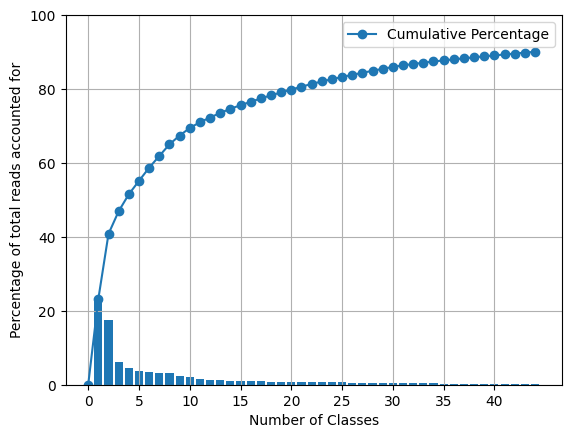

In [21]:
plurals = dict(Phylum="Phyla", Class="Classes", Order="Orders", Family="Families", Genus="Genera", Species="Species")
x,y = list(totals["Index Col"]),list(totals["Cumulative Percentage"])
x.insert(0,0)
y.insert(0,0)
plt.bar(x[1:], np.diff(y))
plt.plot(x, y, marker = 'o', label = 'Cumulative Percentage')
plt.xlabel("Number of "+plurals[colOfInterest])
plt.ylabel("Percentage of total reads accounted for")
plt.ylim(0,100)
plt.xticks(np.arange(0, threshold+1, np.ceil(threshold/10)))
plt.grid()
plt.legend()
plt.show()

# Add * to correlation heatmap to indicate statistical significance
# Pre-process 16S data
# Merge 16S data with meta-data (mani-final) and env2_7days data


In [22]:
# Only first 68 columns are useful (rest are empty). Last useful column is "Mercury (mg/L)"
df = pd.read_csv('summarized_meta_mani-final.csv')
colsToDrop = [col if 'Unnamed' in col else None for col in df.columns]
colsToDrop = [col for col in colsToDrop if col is not None]
df.drop(colsToDrop,axis=1,inplace=True)
df.head()

,Sample,WWTP ID,Date,Position,City,Country,Latitude,Longitude,Continent,Climate type,...,Zinc (mg/L),Lead (mg/L),Copper (mg/L),Arsenic (mg/L),Cadmium (mg/L),Sulphur (mg/L),Sillicon (mg/L),Nickel (mg/L),Chromium (mg/L),Mercury (mg/L)
0,UK01A,UKTM1A,28/01/2015,NewcastleAS,Newcastle,United Kindom,54.7155,-1.6136,Europe,Cfb,...,0.07,0.00,0.03,0.00,0.00,25.69,0.05,0.01,0.00,NaN
1,UK02A,UKTM1A,04/02/2015,NewcastleAS,Newcastle,United Kindom,54.7155,-1.6136,Europe,Cfb,...,0.10,0.00,0.04,0.00,0.00,26.16,0.65,0.01,0.00,NaN
2,UK03A,UKTM1A,11/02/2015,NewcastleAS,Newcastle,United Kindom,54.7155,-1.6136,Europe,Cfb,...,0.06,0.00,0.02,0.01,0.00,25.94,0.17,0.00,0.00,NaN
3,UK04A,UKTM1A,18/02/2015,NewcastleAS,Newcastle,United Kindom,54.7155,-1.6136,Europe,Cfb,...,0.08,0.00,0.02,0.01,0.00,27.65,0.13,0.02,0.00,NaN
4,UK05A,UKTM1A,25/02/2015,NewcastleAS,Newcastle,United Kindom,54.7155,-1.6136,Europe,Cfb,...,0.11,0.00,0.03,0.00,0.00,26.16,0.06,0.01,0.00,NaN


<Axes: ylabel='Frequency'>

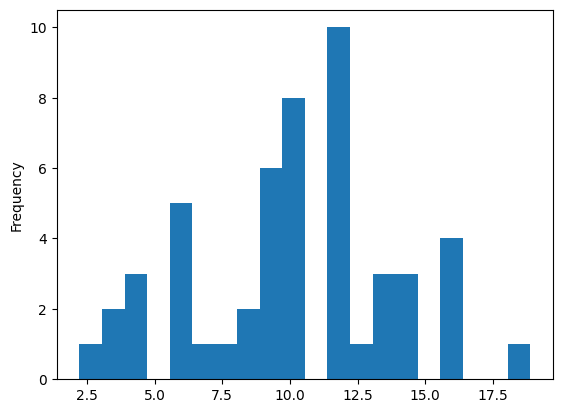

In [23]:
df[df["City"]=="Newcastle"]["Ambient Temperature (℃) Avg.SamplingDate"].plot(kind='hist', bins=20)

In [24]:
print(df.columns)

Index(['Sample', 'WWTP ID', 'Date', 'Position', 'City', 'Country', 'Latitude',
       'Longitude', 'Continent', 'Climate type', 'GDP per capita (dollars)',
       'City population', 'Ambient Temperature (℃) Max.SamplingDate',
       'Ambient Temperature (℃) Avg.SamplingDate',
       'Ambient Temperature (℃) Min.SamplingDate',
       'Ambient Temperature (℃) Max.WeekMean',
       'Ambient Temperature (℃) Avg.WeekMean',
       'Ambient Temperature (℃) Min.WeekMean',
       'Ambient Temperature (℃) Max.WeekMax',
       'Ambient Temperature (℃) Avg.WeekMax',
       'Ambient Temperature (℃) Min.WeekMax', 'Wind (mph) Max.SamplingDate',
       'Wind (mph) Min.SamplingDate', 'Wind (mph) Max.WeekMean',
       'Wind (mph) Min.WeekMean', 'Wind (mph)Max.WeekMax',
       'Wind (mph)Min.WeekMax', 'Precipitation (inches) SamplingDate',
       'Precipitation (inches) WeekMean', 'Precipitation (inches) WeekMax',
       'Precipitation (inches) WeekAccum', 'Precipitation (inches)MonthAccum',
       'Ambi

<Axes: title={'center': 'Samples by year'}, xlabel='Year'>

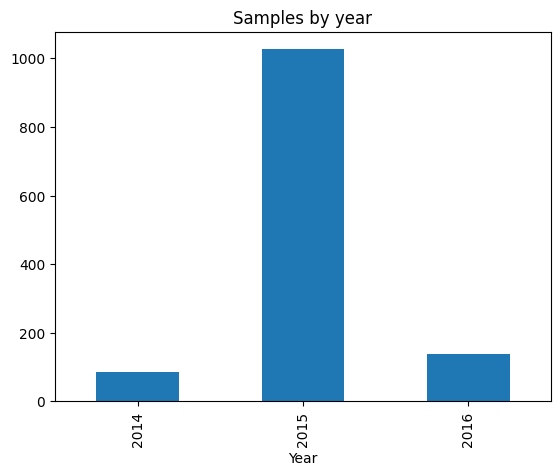

In [25]:
df["Date"] = pd.to_datetime(df["Date"], dayfirst=True)
df["Year"] = df["Date"].dt.year
df["Month"] = df["Date"].dt.month
df["Day"] = df["Date"].dt.day
df["Year"].value_counts().sort_index().plot(kind='bar', title='Samples by year')

<Axes: title={'center': 'Samples by country'}, xlabel='Country'>

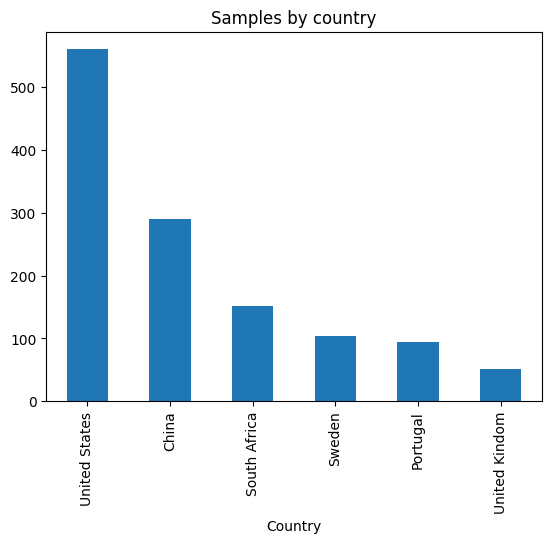

In [26]:
df['Country'].value_counts().plot(kind='bar', title='Samples by country')

<Axes: title={'center': 'Samples by climate type'}, xlabel='Climate type'>

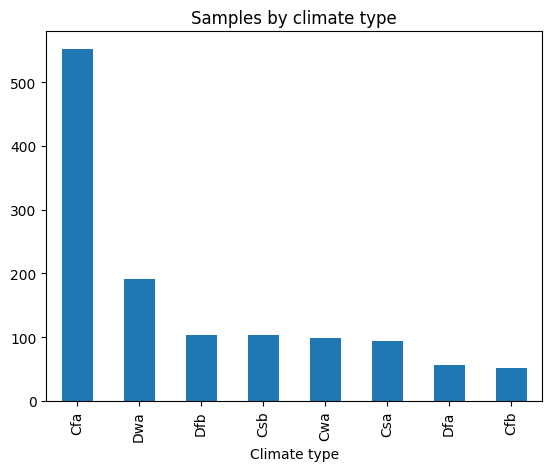

In [27]:
df["Climate type"].value_counts().plot(kind='bar', title='Samples by climate type')

<Axes: title={'center': 'Samples by city'}, xlabel='City'>

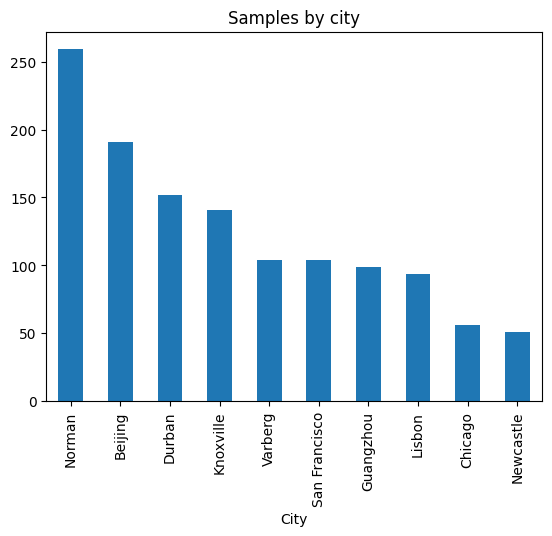

In [28]:
df['City'].value_counts().plot(kind='bar', title='Samples by city')

In [29]:
heavy_metal_cols = ['Calcium (mg/L)', 'Magnesium (mg/L)', 'Potassium (mg/L)', 'Iron (mg/L)',
       'Manganese (mg/L)', 'Aluminium (mg/L)', 'Zinc (mg/L)', 'Lead (mg/L)',
       'Copper (mg/L)', 'Arsenic (mg/L)', 'Cadmium (mg/L)', 'Sulphur (mg/L)',
       'Sillicon (mg/L)', 'Nickel (mg/L)', 'Chromium (mg/L)',
       'Mercury (mg/L)']
for col in heavy_metal_cols:
    df[col] = pd.to_numeric(df[col], errors='coerce')
df['pH'] = pd.to_numeric(df['pH'], errors='coerce')
for column in df.columns:
    #print(column, df[column].dtype)
    print(column)

Sample
WWTP ID
Date
Position
City
Country
Latitude
Longitude
Continent
Climate type
GDP per capita (dollars)
City population
Ambient Temperature (℃) Max.SamplingDate
Ambient Temperature (℃) Avg.SamplingDate
Ambient Temperature (℃) Min.SamplingDate
Ambient Temperature (℃) Max.WeekMean
Ambient Temperature (℃) Avg.WeekMean
Ambient Temperature (℃) Min.WeekMean
Ambient Temperature (℃) Max.WeekMax
Ambient Temperature (℃) Avg.WeekMax
Ambient Temperature (℃) Min.WeekMax
Wind (mph) Max.SamplingDate
Wind (mph) Min.SamplingDate
Wind (mph) Max.WeekMean
Wind (mph) Min.WeekMean
Wind (mph)Max.WeekMax
Wind (mph)Min.WeekMax
Precipitation (inches) SamplingDate
Precipitation (inches) WeekMean
Precipitation (inches) WeekMax
Precipitation (inches) WeekAccum
Precipitation (inches)MonthAccum
Ambient temperature (℃)
Precip (inch)
COD (mg/l) In
COD (mg/l) Out
BOD7 (mg/l) In
BOD7 (mg/l) Out
NH3 (mg/L) In
NH3 (mg/L) Out
TN (mg/L) In
TN (mg/L) Out
TP (mg/L) In
TP (mg/L) Out
pH
DO (mg/L)
AS Temp (oC)
MLSS (mg/l)
M

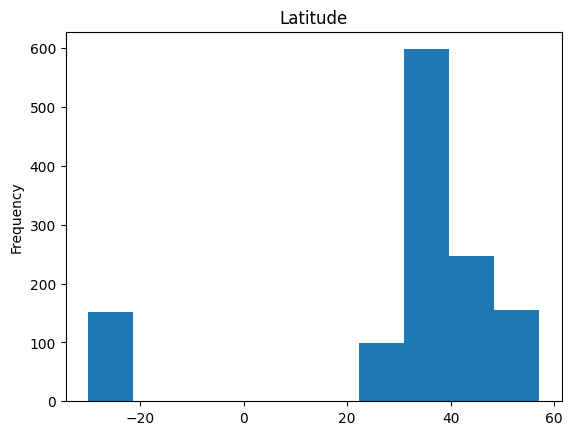

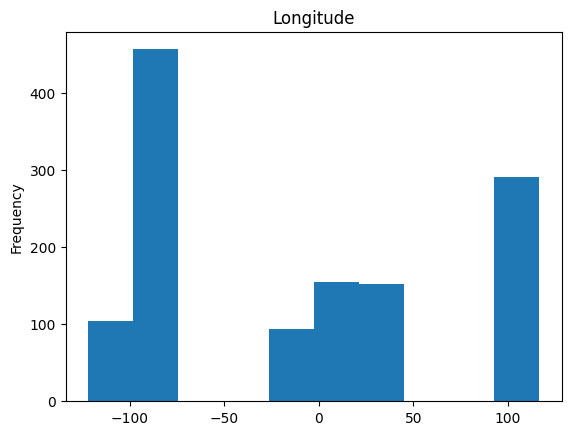

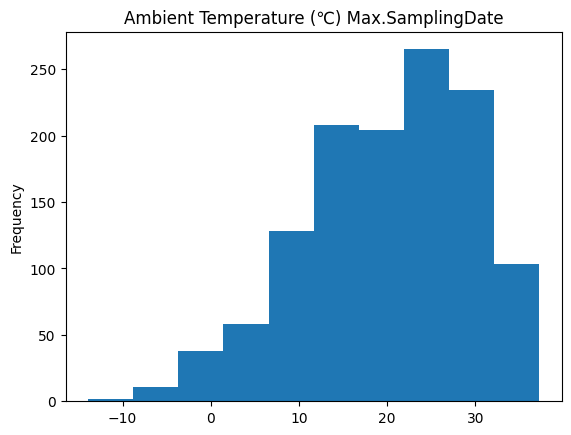

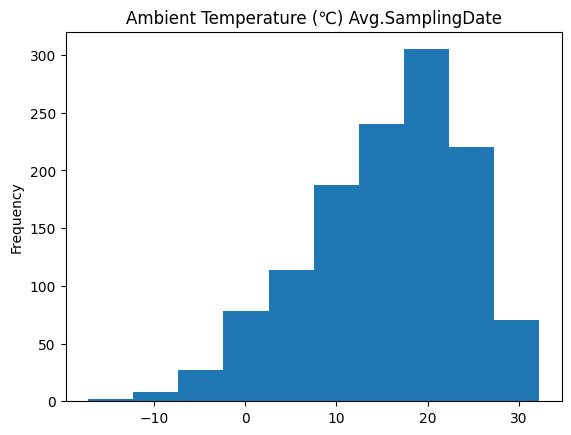

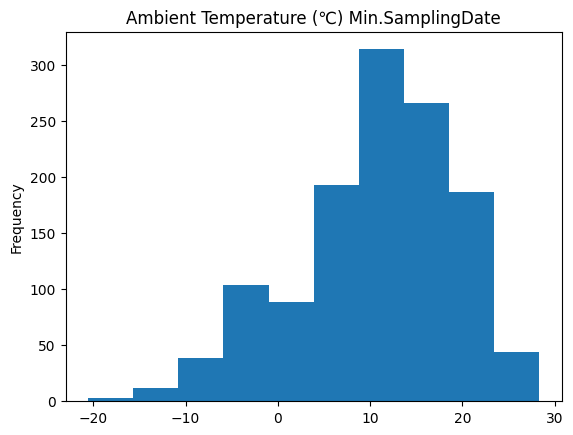

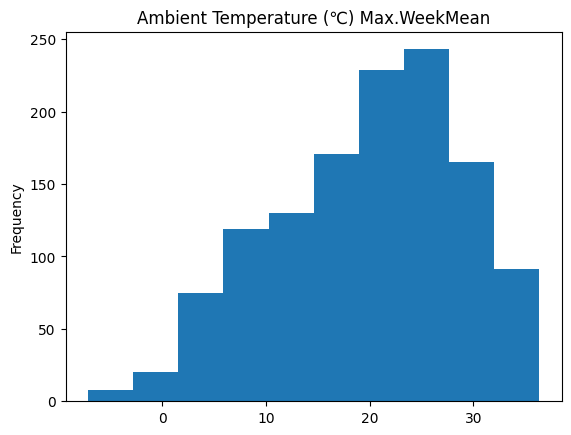

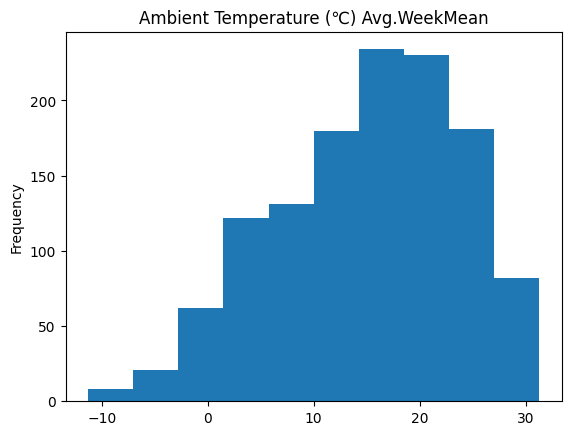

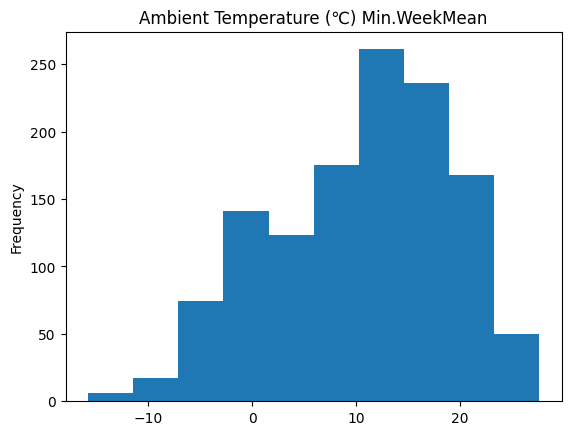

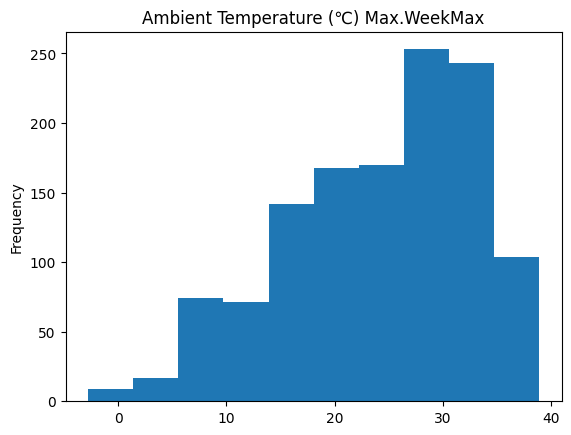

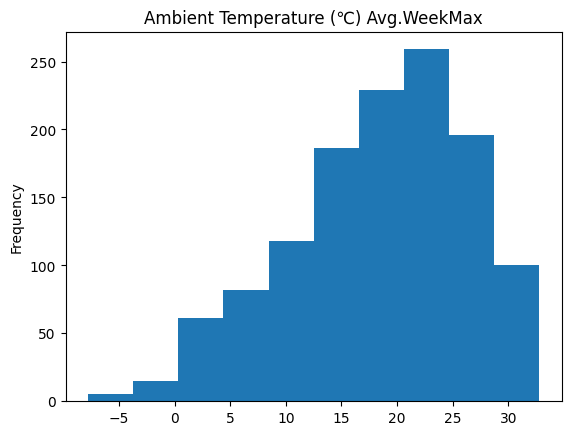

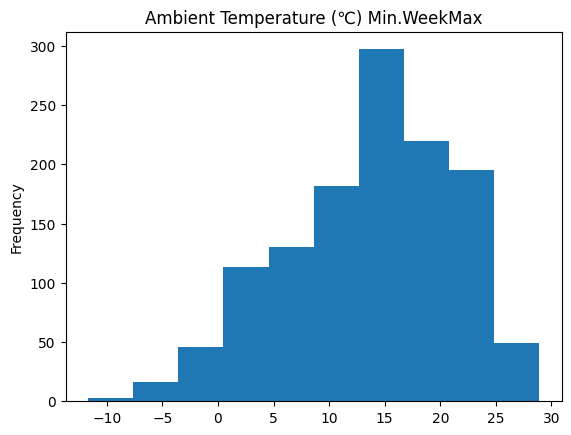

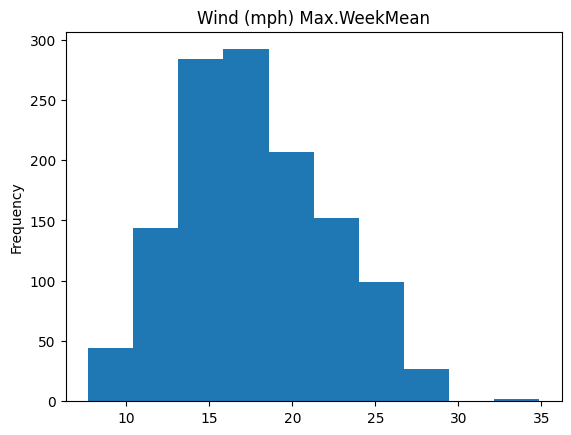

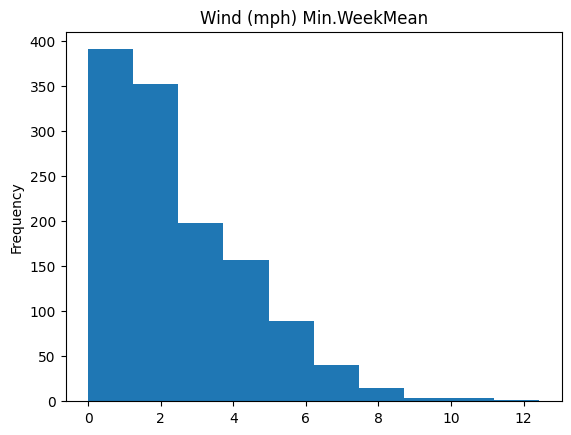

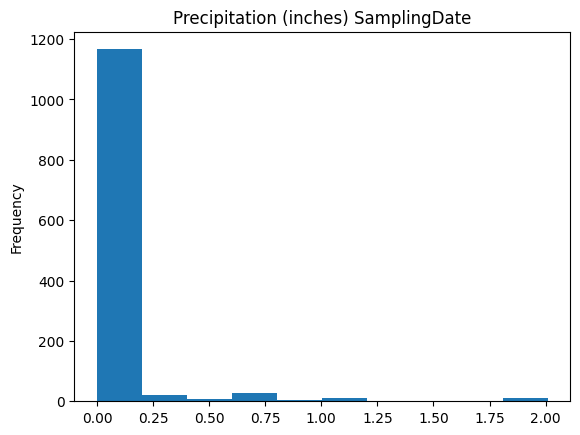

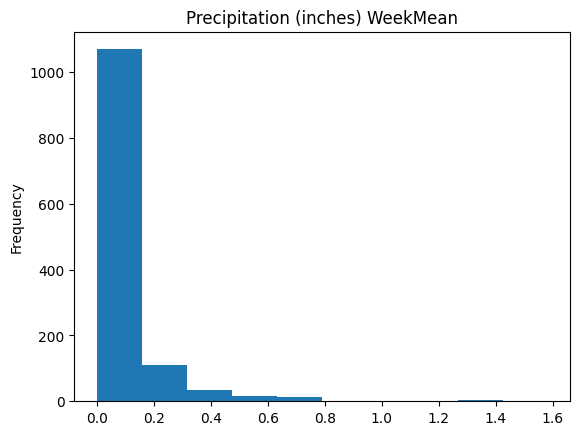

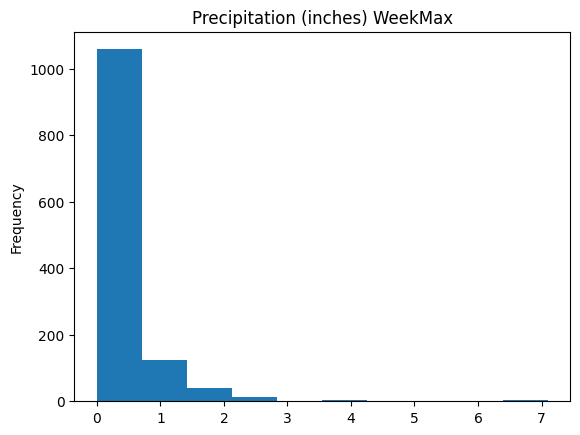

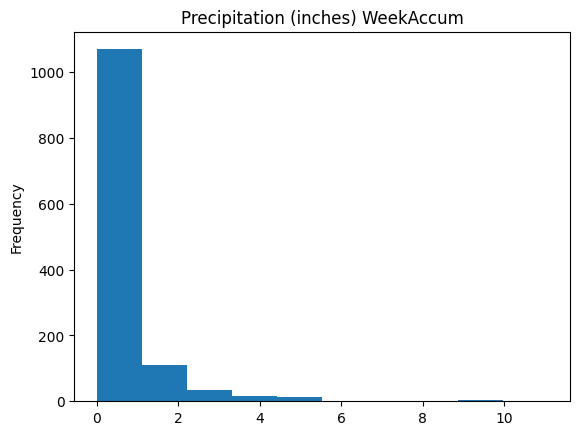

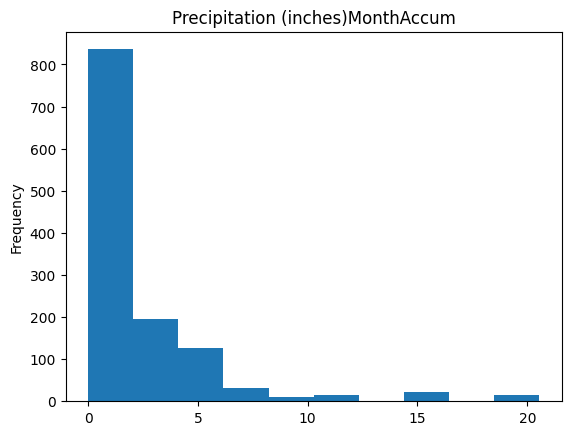

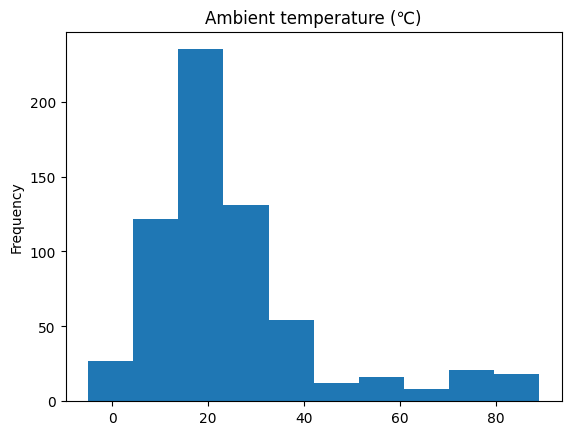

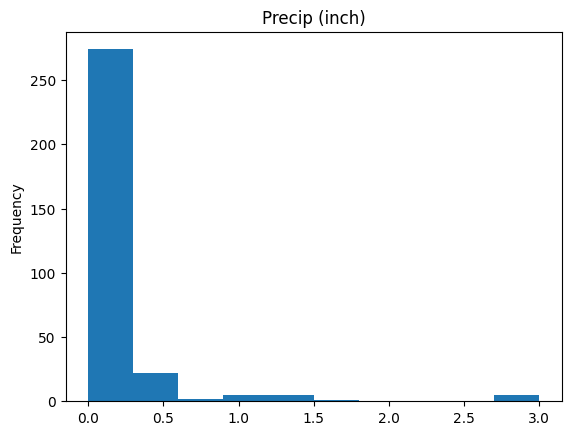

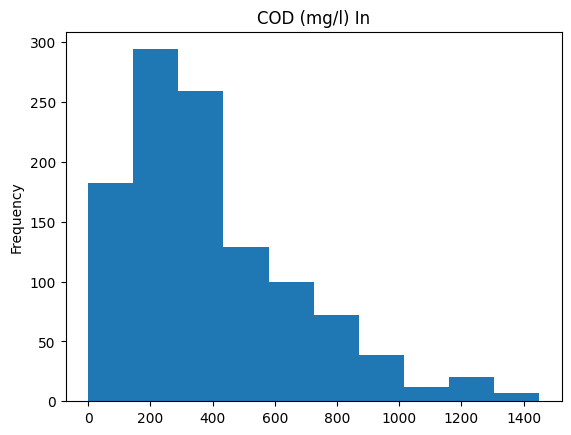

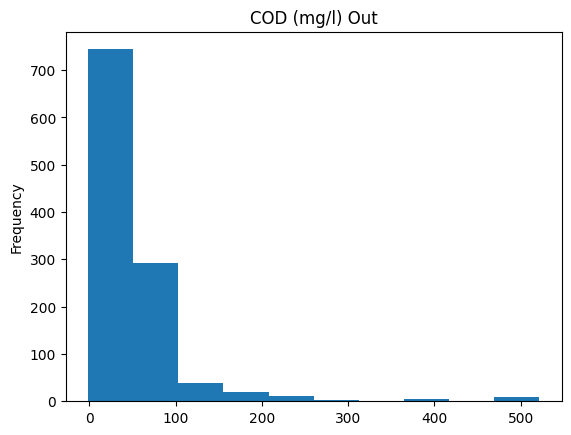

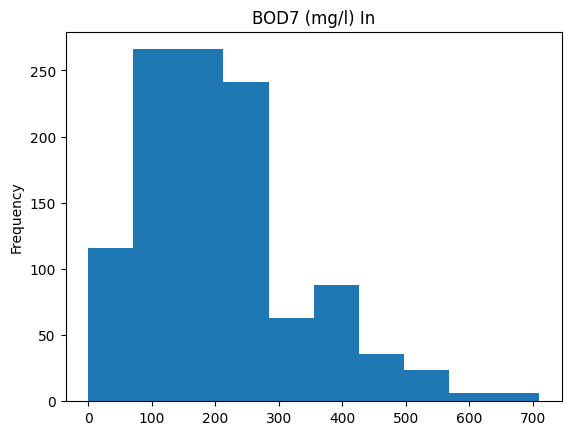

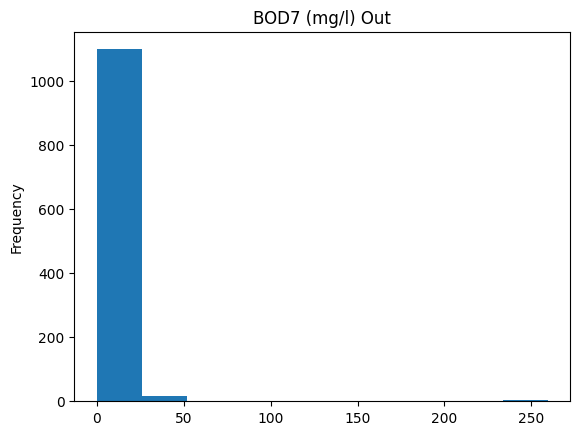

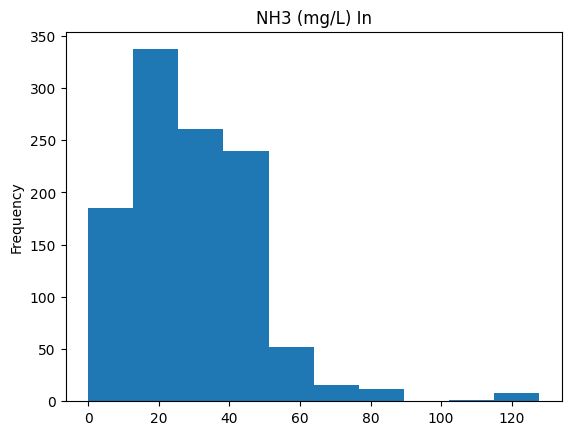

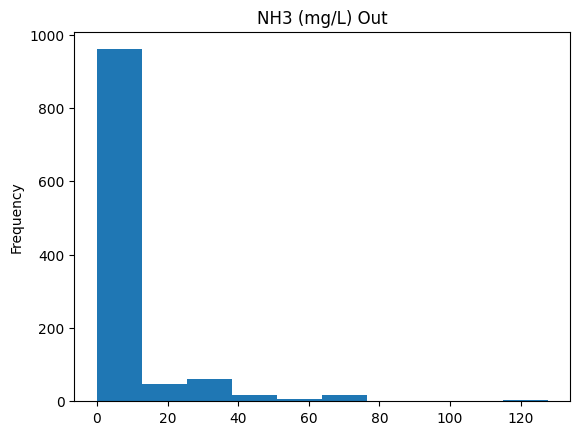

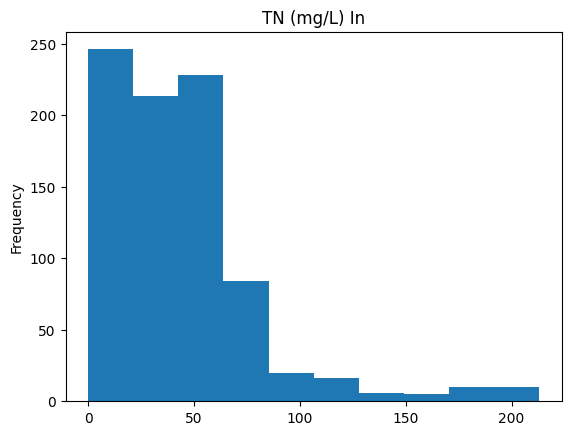

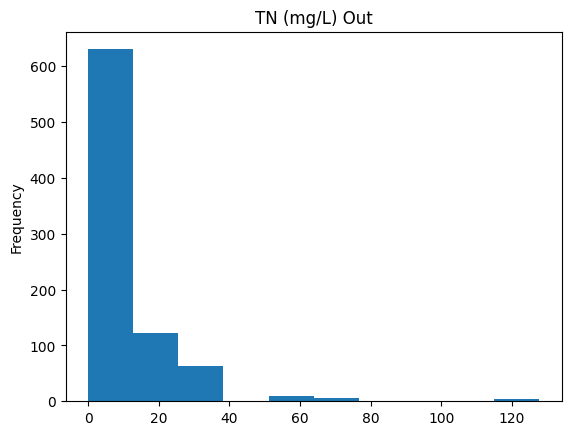

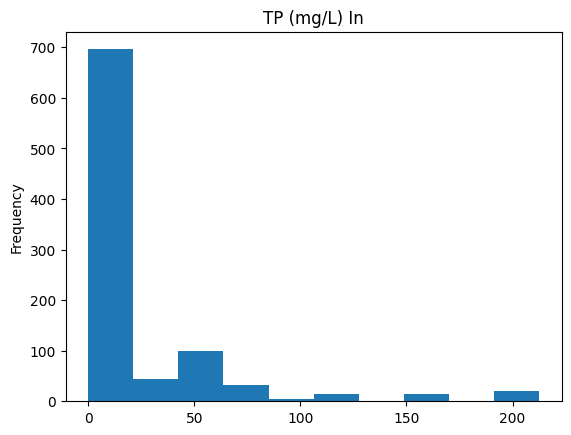

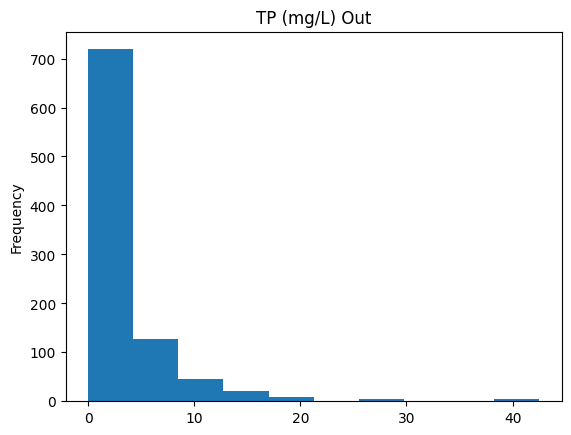

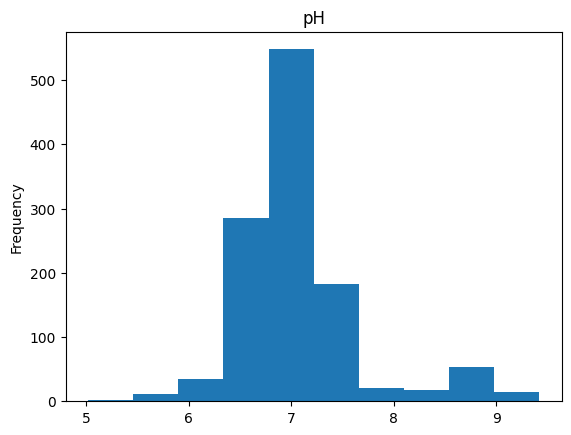

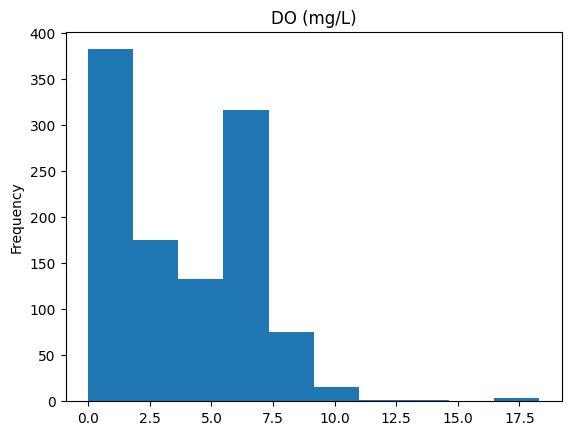

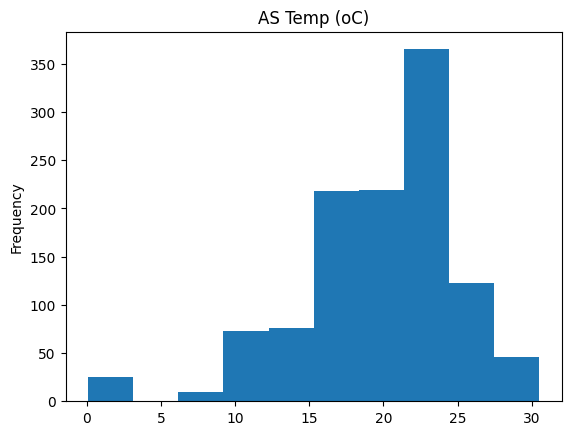

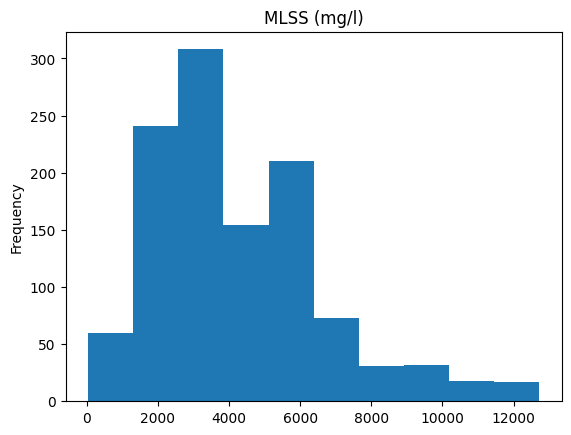

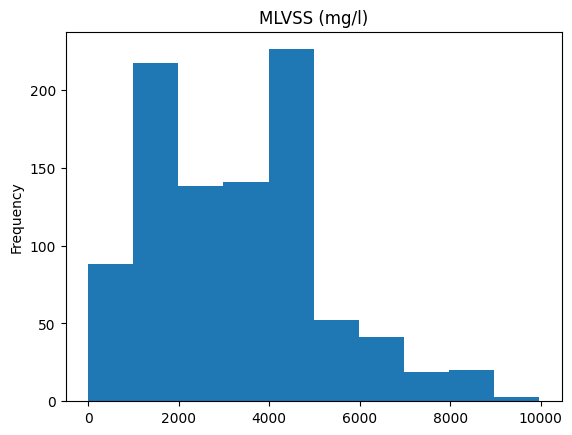

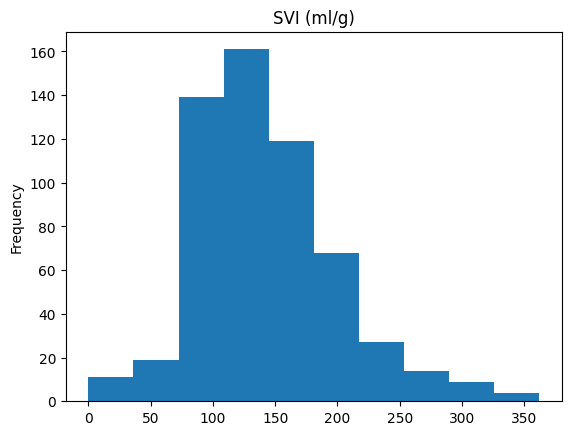

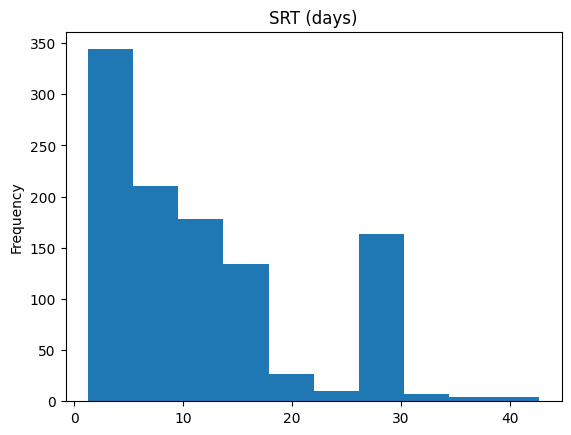

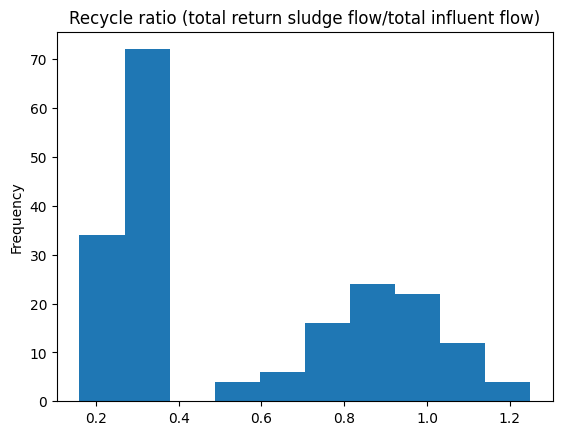

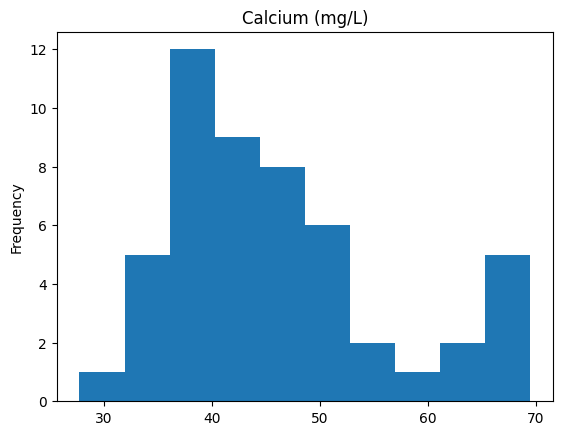

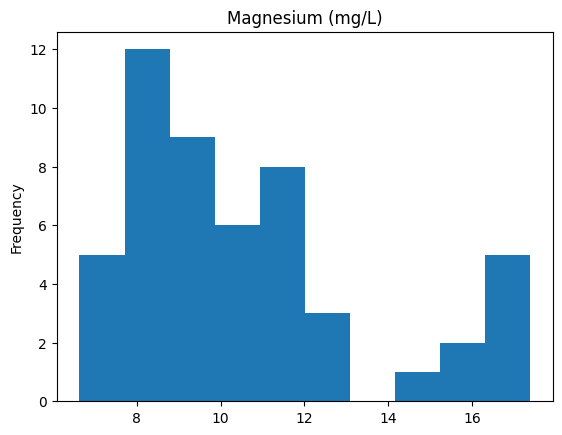

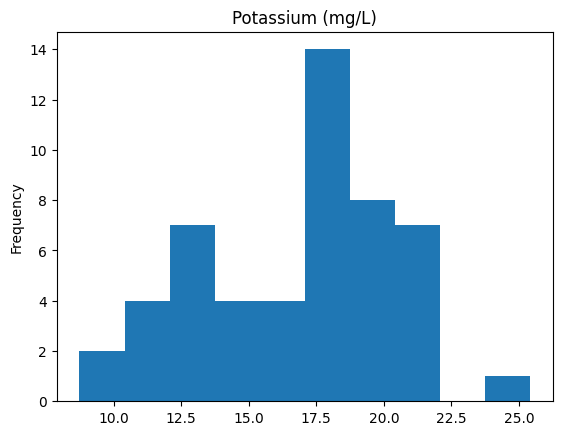

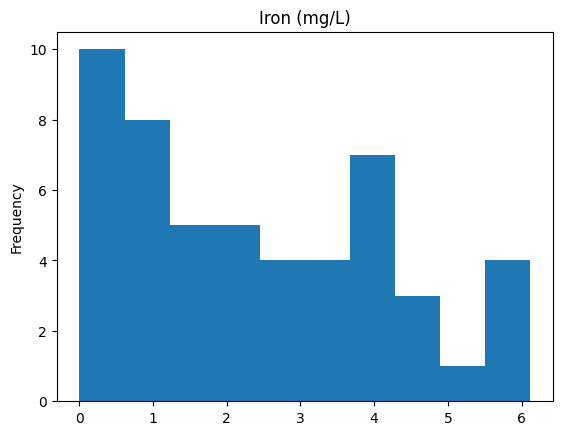

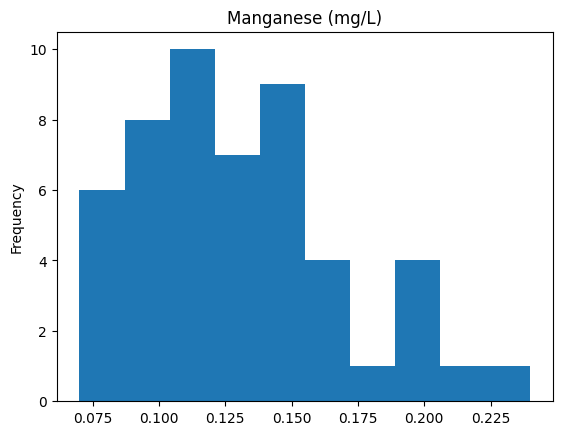

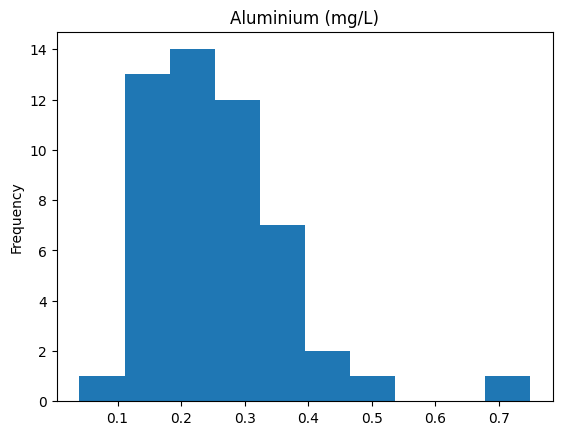

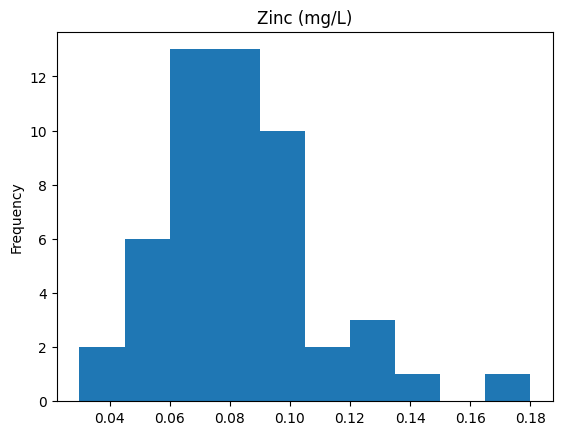

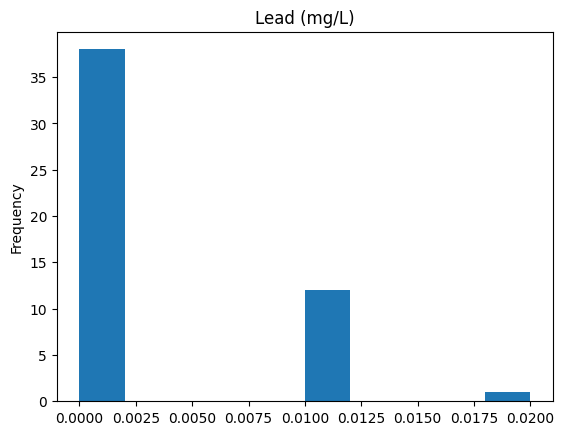

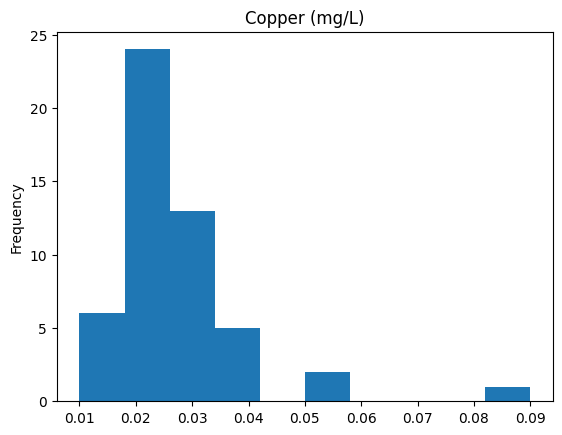

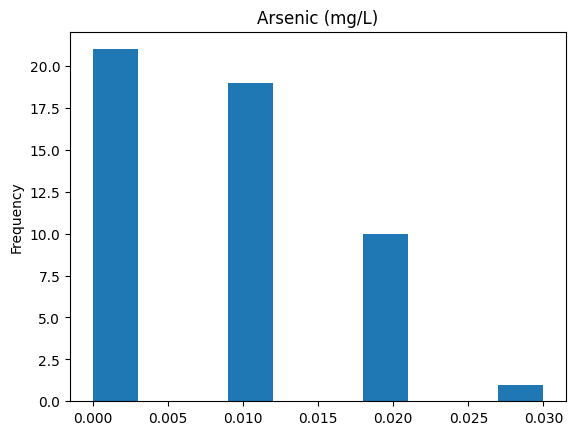

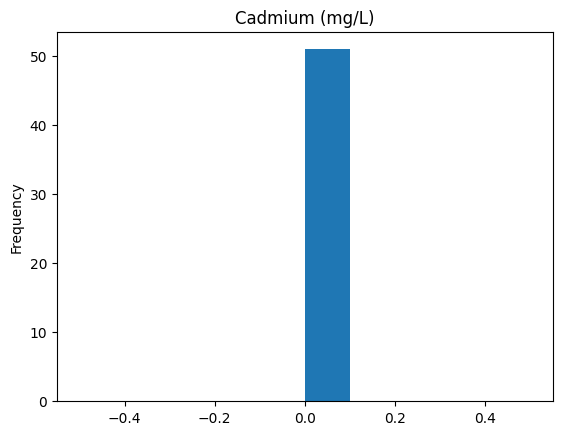

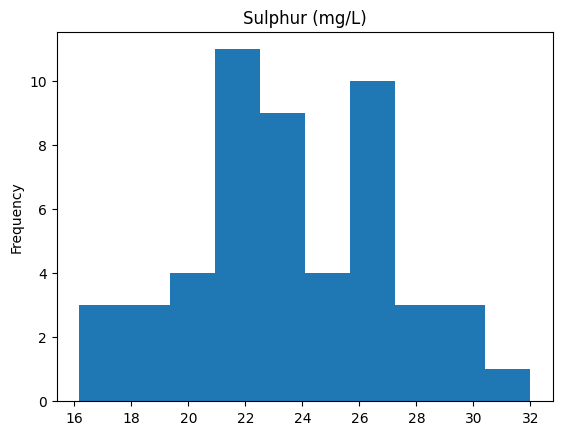

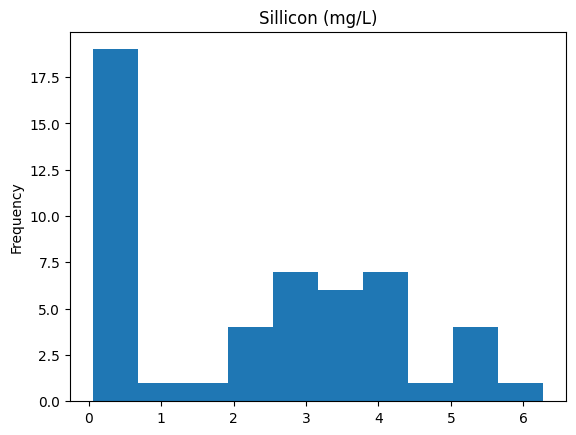

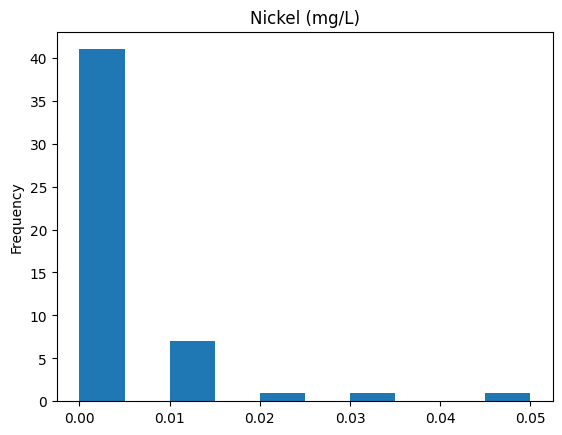

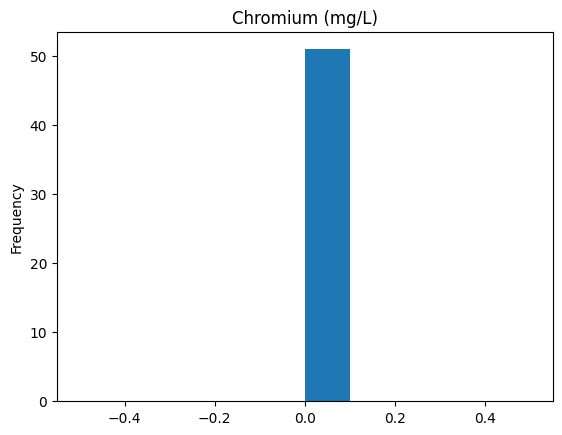

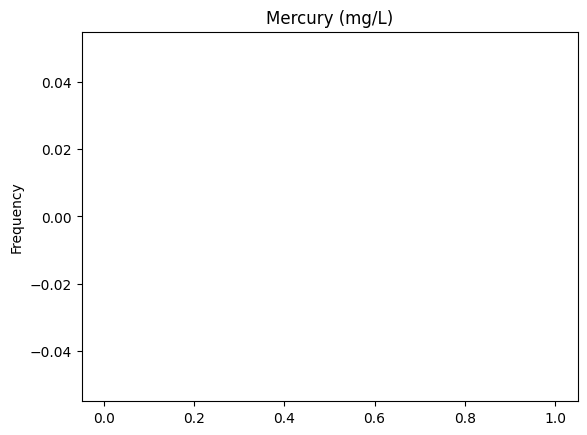

In [30]:
for col in df.columns:
    if df[col].dtype == 'float64':
        df[col].plot(kind='hist', title=col)
        plt.show()

['Calcium (mg/L)', 'Magnesium (mg/L)', 'Potassium (mg/L)', 'Iron (mg/L)', 'Manganese (mg/L)', 'Aluminium (mg/L)', 'Zinc (mg/L)', 'Lead (mg/L)', 'Copper (mg/L)', 'Arsenic (mg/L)', 'Cadmium (mg/L)', 'Sulphur (mg/L)', 'Sillicon (mg/L)', 'Nickel (mg/L)', 'Chromium (mg/L)', 'Mercury (mg/L)']


,Calcium (mg/L),Magnesium (mg/L),Potassium (mg/L),Iron (mg/L),Manganese (mg/L),Aluminium (mg/L),Zinc (mg/L),Lead (mg/L),Copper (mg/L),Arsenic (mg/L),Sulphur (mg/L),Sillicon (mg/L),Nickel (mg/L)
Calcium (mg/L),1.0***,0.95***,-0.42**,-0.15,-0.26,-0.0,0.04,0.12,-0.28*,0.47***,0.57***,0.3*,-0.12
Magnesium (mg/L),0.95***,1.0***,-0.34*,-0.1,-0.35*,-0.02,-0.0,-0.06,-0.21,0.37**,0.65***,0.18,-0.18
Potassium (mg/L),-0.42**,-0.34*,1.0***,0.04,0.42**,0.03,0.18,-0.2,0.46***,-0.39**,0.23,-0.31*,0.1
Iron (mg/L),-0.15,-0.1,0.04,1.0***,-0.06,0.02,-0.11,-0.14,0.19,-0.06,-0.13,0.05,0.01
Manganese (mg/L),-0.26,-0.35*,0.42**,-0.06,1.0***,0.28*,0.32*,0.35*,0.34*,-0.26,-0.13,0.09,-0.01
Aluminium (mg/L),-0.0,-0.02,0.03,0.02,0.28*,1.0***,0.35*,0.24,0.25,0.1,-0.09,0.06,0.03
Zinc (mg/L),0.04,-0.0,0.18,-0.11,0.32*,0.35*,1.0***,0.12,0.34*,-0.08,0.02,-0.03,0.05
Lead (mg/L),0.12,-0.06,-0.2,-0.14,0.35*,0.24,0.12,1.0***,-0.1,0.17,-0.09,0.34*,0.11
Copper (mg/L),-0.28*,-0.21,0.46***,0.19,0.34*,0.25,0.34*,-0.1,1.0***,-0.42**,0.0,-0.26,-0.05
Arsenic (mg/L),0.47***,0.37**,-0.39**,-0.06,-0.26,0.1,-0.08,0.17,-0.42**,1.0***,0.15,0.48***,-0.06


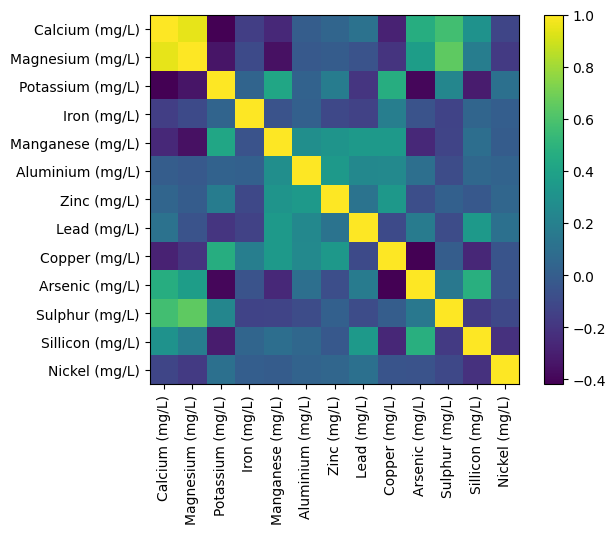

In [31]:
import matplotlib.pyplot as plt
from scipy.stats import pearsonr
heavy_metal_cols = ['Calcium (mg/L)', 'Magnesium (mg/L)', 'Potassium (mg/L)', 'Iron (mg/L)',
       'Manganese (mg/L)', 'Aluminium (mg/L)', 'Zinc (mg/L)', 'Lead (mg/L)',
       'Copper (mg/L)', 'Arsenic (mg/L)', 'Cadmium (mg/L)', 'Sulphur (mg/L)',
       'Sillicon (mg/L)', 'Nickel (mg/L)', 'Chromium (mg/L)',
       'Mercury (mg/L)']
print(heavy_metal_cols)
try: 
    heavy_metal_cols.remove('Cadmium (mg/L)')
    heavy_metal_cols.remove('Chromium (mg/L)')
    heavy_metal_cols.remove('Mercury (mg/L)')
except:
    pass
rho = df[heavy_metal_cols].corr()
pval = df[heavy_metal_cols].corr(method=lambda x, y: pearsonr(x, y)[1]) - np.eye(*rho.shape)
p = pval.applymap(lambda x: ''.join(['*' for t in [.05, .01, .001] if x<=t]))
plt.imshow(df[heavy_metal_cols].corr(), interpolation='nearest')
plt.colorbar()
plt.xticks(range(len(heavy_metal_cols)), heavy_metal_cols, rotation=90);
plt.yticks(range(len(heavy_metal_cols)), heavy_metal_cols, rotation=0);

pval = df[heavy_metal_cols].corr(method=lambda x, y: pearsonr(x, y)[1]) - np.eye(*rho.shape)
p = pval.applymap(lambda x: ''.join(['*' for t in [.05, .01, .001] if x<=t]))
rho.round(2).astype(str) + p

In [32]:
df[heavy_metal_cols].corr()

,Calcium (mg/L),Magnesium (mg/L),Potassium (mg/L),Iron (mg/L),Manganese (mg/L),Aluminium (mg/L),Zinc (mg/L),Lead (mg/L),Copper (mg/L),Arsenic (mg/L),Sulphur (mg/L),Sillicon (mg/L),Nickel (mg/L)
Calcium (mg/L),1.000000,0.946264,-0.418763,-0.153979,-0.256238,-0.000711,0.042192,0.115519,-0.282803,0.466970,0.571158,0.303728,-0.122243
Magnesium (mg/L),0.946264,1.000000,-0.338926,-0.102637,-0.353913,-0.023476,-0.004163,-0.057029,-0.206950,0.371411,0.647925,0.180696,-0.178920
Potassium (mg/L),-0.418763,-0.338926,1.000000,0.038093,0.419204,0.029679,0.178343,-0.201550,0.463316,-0.391142,0.231973,-0.312353,0.104949
Iron (mg/L),-0.153979,-0.102637,0.038093,1.000000,-0.058350,0.015343,-0.111317,-0.137132,0.190859,-0.056544,-0.134066,0.046611,0.006132
Manganese (mg/L),-0.256238,-0.353913,0.419204,-0.058350,1.000000,0.281121,0.318245,0.346324,0.341470,-0.257496,-0.126455,0.093581,-0.007652
Aluminium (mg/L),-0.000711,-0.023476,0.029679,0.015343,0.281121,1.000000,0.346888,0.242907,0.250869,0.099901,-0.088560,0.056953,0.030381
Zinc (mg/L),0.042192,-0.004163,0.178343,-0.111317,0.318245,0.346888,1.000000,0.119168,0.339260,-0.075449,0.016760,-0.026140,0.047510
Lead (mg/L),0.115519,-0.057029,-0.201550,-0.137132,0.346324,0.242907,0.119168,1.000000,-0.098717,0.172204,-0.089649,0.344036,0.106705
Copper (mg/L),-0.282803,-0.206950,0.463316,0.190859,0.341470,0.250869,0.339260,-0.098717,1.000000,-0.417906,0.000537,-0.261150,-0.050890
Arsenic (mg/L),0.466970,0.371411,-0.391142,-0.056544,-0.257496,0.099901,-0.075449,0.172204,-0.417906,1.000000,0.148119,0.475401,-0.055170


Index(['Sample', 'WWTP ID', 'Date', 'Position', 'City', 'Country', 'Latitude',
       'Longitude', 'Continent', 'Climate type', 'GDP per capita (dollars)',
       'City population', 'Ambient Temperature (℃) Max.SamplingDate',
       'Ambient Temperature (℃) Avg.SamplingDate',
       'Ambient Temperature (℃) Min.SamplingDate',
       'Ambient Temperature (℃) Max.WeekMean',
       'Ambient Temperature (℃) Avg.WeekMean',
       'Ambient Temperature (℃) Min.WeekMean',
       'Ambient Temperature (℃) Max.WeekMax',
       'Ambient Temperature (℃) Avg.WeekMax',
       'Ambient Temperature (℃) Min.WeekMax', 'Wind (mph) Max.SamplingDate',
       'Wind (mph) Min.SamplingDate', 'Wind (mph) Max.WeekMean',
       'Wind (mph) Min.WeekMean', 'Wind (mph)Max.WeekMax',
       'Wind (mph)Min.WeekMax', 'Precipitation (inches) SamplingDate',
       'Precipitation (inches) WeekMean', 'Precipitation (inches) WeekMax',
       'Precipitation (inches) WeekAccum', 'Precipitation (inches)MonthAccum',
       'Ambi

KeyError: 'HRT (hours)'

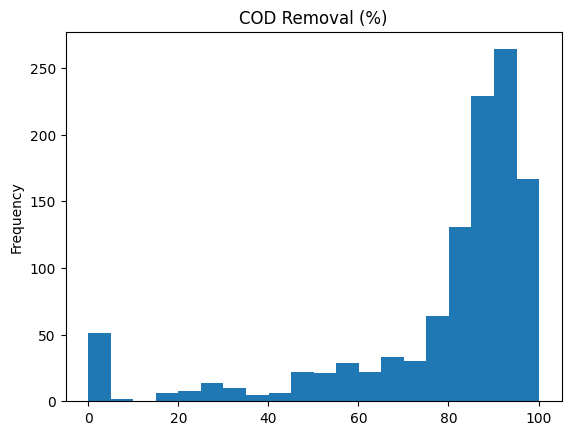

In [41]:
# Performance
print(df.columns)
df["COD Removal (%)"] = (df['COD (mg/l) In']-df['COD (mg/l) Out'])/df['COD (mg/l) In']*100
df["COD Removal (%)"].clip(lower=0, inplace = True)
df["COD Removal (%)"].plot(kind='hist', bins=20, title = "COD Removal (%)")

df["COD Removal Rate mg/mg/d"] = (df['COD (mg/l) In']-df['COD (mg/l) Out'])/(df['HRT (hours)']*df["MLSS (mg/l)"])